In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers                   import ModelParameters
from ydata_synthetic.preprocessing.timeseries       import processed_stock
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
from ydata_synthetic.synthesizers.timeseries        import TimeGAN

In [2]:
#Specific to TimeGANs
seq_len       = 24
n_seq         = 5  # ohlcv
hidden_dim    = 24
gamma         = 1

noise_dim     = 32
dim           = 128
batch_size    = 128

log_step      = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size = batch_size,
                           lr         = learning_rate,
                           noise_dim  = noise_dim,
                           layers_dim = dim)

In [3]:
asset = "btcusdt".upper()

df = pd.read_csv(f"./data/{asset}/{asset}-1m.csv", parse_dates=True, index_col="timestamp")
df = df.rename(columns={"op": "Open", "hi": "High", "lo":"Low", "cl":"Close", "volume": "Volume"})

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00+00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00+00:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00+00:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00+00:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00+00:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2022-09-10 08:19:00+00:00,21313.24,21328.01,21309.41,21326.15,165.289480
2022-09-10 08:20:00+00:00,21326.75,21350.00,21325.37,21348.74,209.965260
2022-09-10 08:21:00+00:00,21348.74,21351.40,21328.66,21330.08,269.798810


In [4]:
temp_data      = df.iloc[-200:].values
temp_processed = real_data_loading(data=temp_data, seq_len=seq_len)

temp_processed

[array([[0.66515028, 0.63142305, 0.6959414 , 0.68370745, 0.12765638],
        [0.66100731, 0.60128783, 0.69367914, 0.66759633, 0.07382276],
        [0.63406445, 0.60752093, 0.67307641, 0.66101649, 0.17286558],
        [0.63122123, 0.57671603, 0.65441275, 0.63410143, 0.15311358],
        [0.62921744, 0.57535093, 0.66682826, 0.63123121, 0.04300605],
        [0.60048741, 0.56976175, 0.63488729, 0.62922748, 0.05478376],
        [0.63663688, 0.57687057, 0.61983248, 0.60288105, 0.14338849],
        [0.57722719, 0.57396008, 0.61651989, 0.63664672, 0.17177529],
        [0.62867587, 0.57653574, 0.61320729, 0.5741518 , 0.12653099],
        [0.57963715, 0.55814552, 0.61331502, 0.62389321, 0.23615677],
        [0.57376117, 0.5354282 , 0.60211144, 0.58135442, 0.16682629],
        [0.60484701, 0.53823567, 0.60388893, 0.57377271, 0.19975326],
        [0.65060926, 0.58269156, 0.62861221, 0.60309767, 0.2246027 ],
        [0.67852694, 0.62513844, 0.65812933, 0.65061872, 0.18813257],
        [0.74045491,

In [5]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(temp_processed, train_steps=500)
    synth.save('synthesizer_stock.pkl')

2022-09-21 14:35:21.897683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 14:35:21.903444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 14:35:21.903851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 14:35:21.906985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
synthetic_data = synth.sample(10)

synthetic_data

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


array([[[0.34332737, 0.3004916 , 0.35012951, 0.32339573, 0.11333822],
        [0.46061954, 0.431348  , 0.428328  , 0.43377262, 0.20458588],
        [0.5194798 , 0.48296064, 0.4793086 , 0.45039582, 0.3987855 ],
        ...,
        [0.8286002 , 0.7827015 , 0.8623769 , 0.83428466, 0.08809438],
        [0.719175  , 0.6454667 , 0.74497956, 0.69420224, 0.07380284],
        [0.58865696, 0.47954425, 0.6163468 , 0.54711133, 0.07503536]],

       [[0.4194446 , 0.37210998, 0.43245873, 0.40559092, 0.1056662 ],
        [0.4622017 , 0.4140285 , 0.4748562 , 0.45327234, 0.09998011],
        [0.36604312, 0.3294836 , 0.42814556, 0.40103883, 0.06393279],
        ...,
        [0.851286  , 0.8055989 , 0.8592394 , 0.84604305, 0.13541435],
        [0.88359344, 0.82670015, 0.8924087 , 0.87458855, 0.1090789 ],
        [0.89114857, 0.8316358 , 0.9065402 , 0.8832214 , 0.08902705]],

       [[0.75523436, 0.6989064 , 0.76321   , 0.75369006, 0.1236963 ],
        [0.64386827, 0.6014837 , 0.7050919 , 0.65764534, 0.0

In [8]:
synthetic_data.shape

(128, 24, 5)

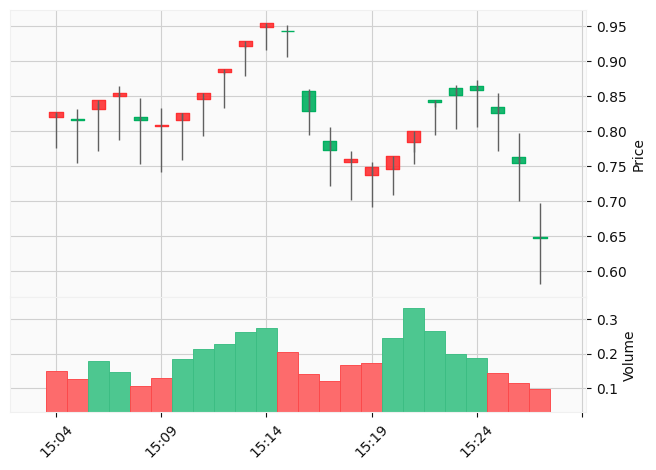

In [16]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

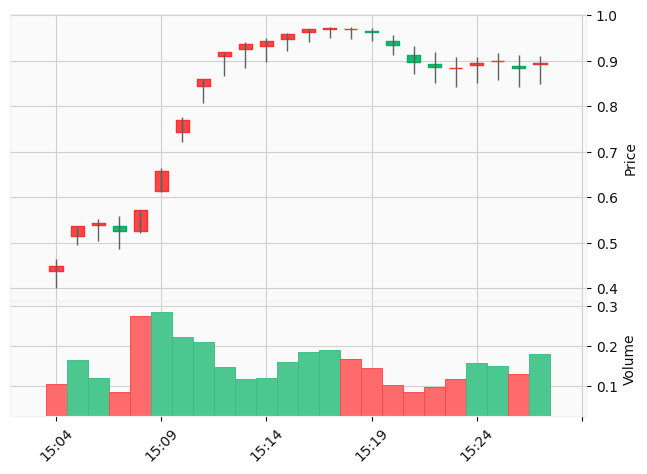

In [17]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

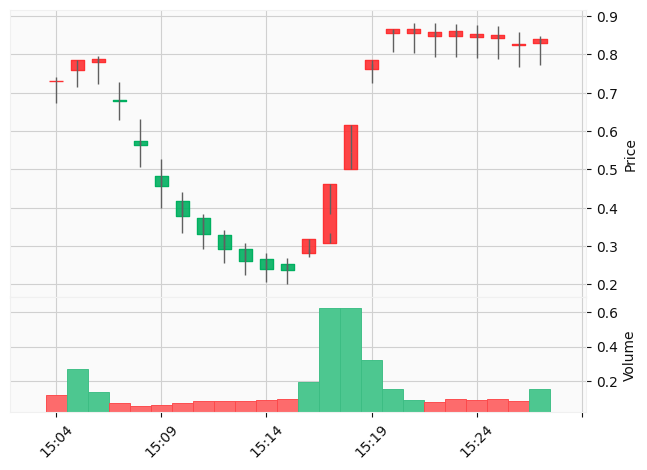

In [18]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

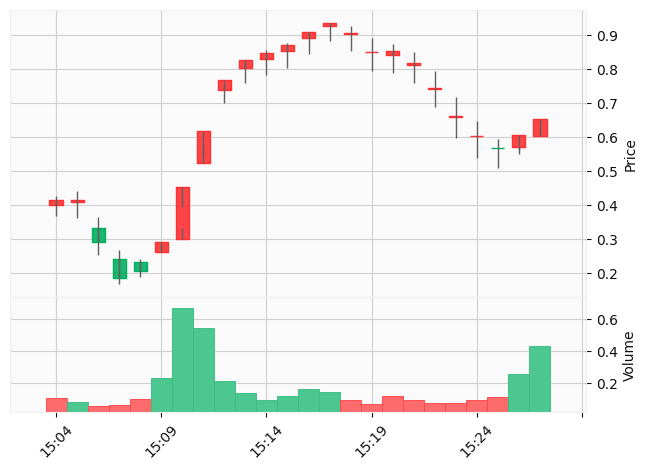

In [19]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

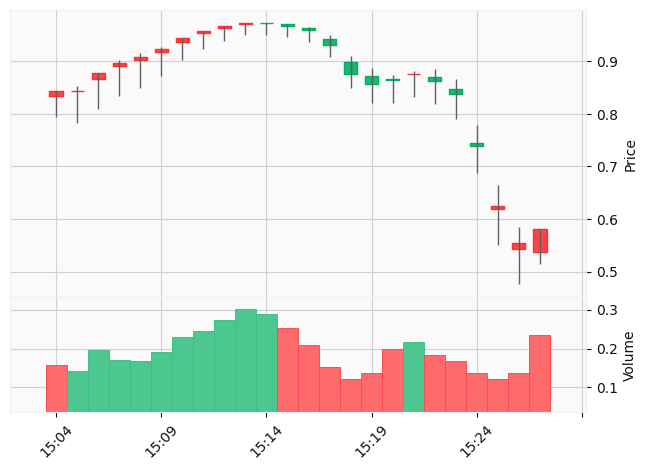

In [20]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

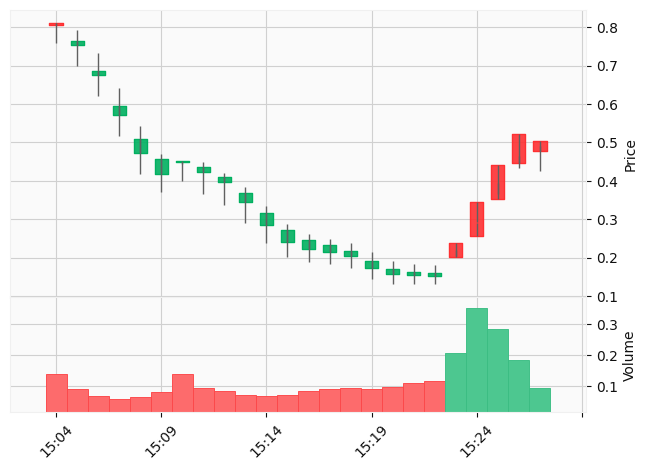

In [21]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

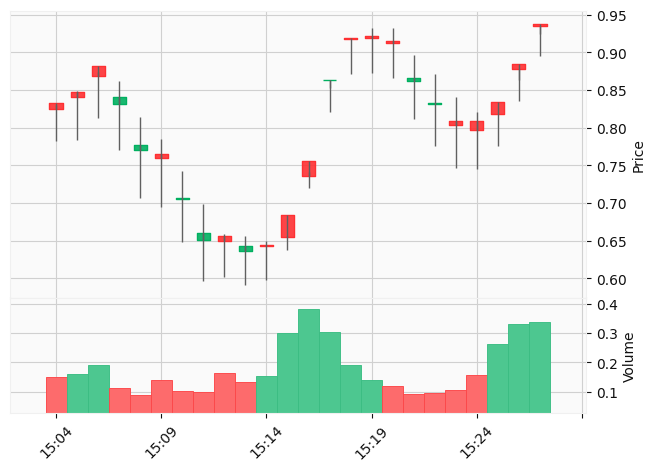

In [22]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

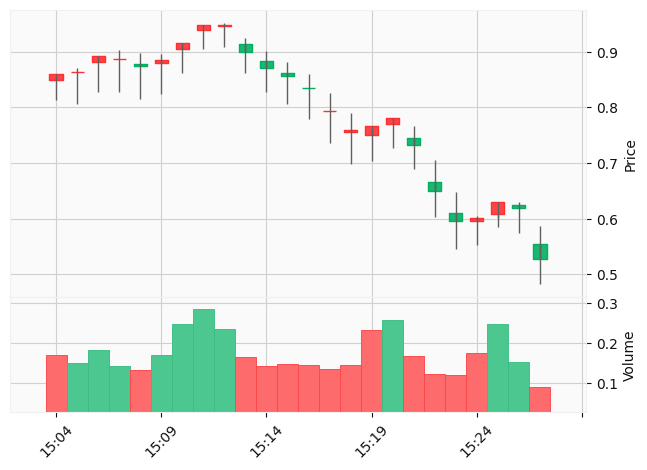

In [23]:
random_idx = np.random.randint(len(synthetic_data))
temp_df = pd.DataFrame(synthetic_data[random_idx], columns=['Open', 'High', 'Low', 'Close', 'Volume'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)